In [2]:
#| default_exp attention_rollout

In [1]:
#| hide
!nvidia-smi

Wed Jul 26 22:30:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:B1:00.0 Off |                  N/A |
| 22%   25C    P8     9W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:B2:00.0 Off |                  N/A |
| 22%   

In [2]:
#| hide
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"

# Allow access to the web
os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'

In [3]:
#| export
import torch

In [4]:
#| hide
torch.__version__

'1.13.1+cu117'

In [5]:
#| hide
ngpu = torch.cuda.device_count()
for gpu_id in range(ngpu):
    gpu = torch.cuda.get_device_name(gpu_id)
    print(f"GPU:{gpu_id} {gpu}")

GPU:0 NVIDIA GeForce RTX 2080 Ti
GPU:1 NVIDIA GeForce RTX 2080 Ti


In [6]:
#| hide
import nbdev

### Implementation beings here

In [7]:
#| export
import sys
sys.path.append('./ScoreCAM')

In [30]:
#| export
import sys
import os
from PIL import Image, ImageDraw
import imageio
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights, ResNet50_Weights, RegNet_Y_16GF_Weights
from matplotlib import pyplot as plt
import numpy as np
import timm
from timm.models.vision_transformer import trunc_normal_

# Attention rollout
from abid.attention_rollout import rollout, VITAttentionRollout, grad_rollout, VITAttentionGradRollout

# CAM-related
from cam import CAM, GradCAM, GradCAMpp, ScoreCAM, SmoothGradCAMpp


In [9]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

vit_model = torch.hub.load('facebookresearch/deit:main',  'deit_tiny_patch16_224', pretrained=True).to(device)
vit_model.eval();

classes = open("classes.txt").read().splitlines()

Using cache found in /home/hashimi/.cache/torch/hub/facebookresearch_deit_main


In [10]:
#| export
def vit_saliency_map(img, model, discard_ratio=0.9,
                     head_fusion='max', category_index=None, use_cuda=True):
    gpu_reference_tensor = next(model.parameters())

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    
    input_tensor = transform(img).unsqueeze(0)
    if use_cuda: input_tensor = input_tensor.cuda()

    attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
                                            discard_ratio=discard_ratio)
    mask, output = attention_rollout(input_tensor)

    probs = torch.nn.functional.softmax(output, dim=1)
    cat_idx = torch.argmax(probs).item()
    
    return probs, cat_idx, mask

def visualize_saliency_overlay(img, mask, probs, cat_idx, classes):
    
#     patch_size = 16
#     steps = int(224/patch_size)
#     for x in range(steps-1):
#     pos = (x+1)*patch_size
#     np_img[:, pos:pos+1, :] = 0
#     np_img[pos:pos+1, :, :] = 0

    np_img = np.array(img)
    fig, ax = plt.subplots()
    heatmap = Image.fromarray(mask)
    heatmap = np.array(heatmap.resize((np_img.shape[0], np_img.shape[1])))
    ax.imshow(np_img)
    heatmap = (heatmap / np.max(heatmap)) * 255.0
    ax.imshow(heatmap, cmap='turbo', # seismic, hot, Reds
              alpha=0.5)
    ax.set_title(f"Class: {classes[cat_idx]} ({probs[0, cat_idx].item()*100:.2f}%)")
    plt.show()
    
    return heatmap

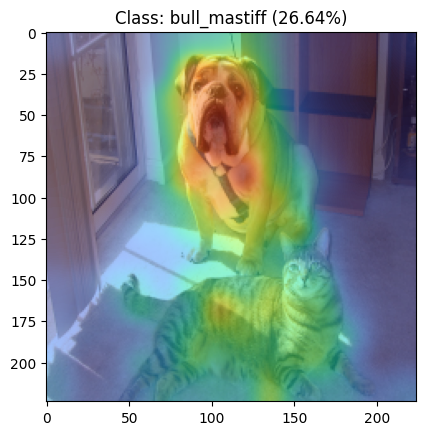

243


In [11]:
img = Image.open('./examples/input.png').resize((224, 224))

# Run through vit and get its attention activations as saliency map
probs, cat_idx, mask = vit_saliency_map(img, vit_model)

# Visualize
vit_heatmap = visualize_saliency_overlay(img, mask, probs, cat_idx, classes)
print(cat_idx)

(14, 14)

### Conv Model

In [12]:
device = torch.device("cuda" if use_cuda else "cpu")
regnet_model = models.regnet_y_16gf(weights=RegNet_Y_16GF_Weights.IMAGENET1K_V2).to(device)
regnet_model.eval()

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [13]:
resnet_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
regnet_model.trunk_output[3][0].f.c[0]

Conv2d(3024, 3024, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [14]:
# !git clone https://github.com/yiskw713/ScoreCAM.git

Cloning into 'ScoreCAM'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 25 (delta 2), reused 20 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), 3.29 MiB | 7.56 MiB/s, done.


In [15]:
#| export
from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM

In [16]:
img = Image.open('./examples/input.png').resize((256, 256))
transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

input_tensor = transform(img).unsqueeze(0).to(device)
if use_cuda: input_tensor = input_tensor.cuda()
input_tensor.shape

torch.Size([1, 3, 256, 256])

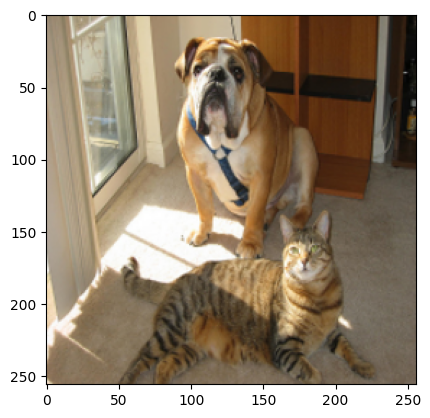

In [17]:
plt.imshow(img)

In [18]:
out = resnet_model(input_tensor)

In [19]:
cat_idx = torch.argmax(out.squeeze()).to("cpu").item()

bull_mastiff


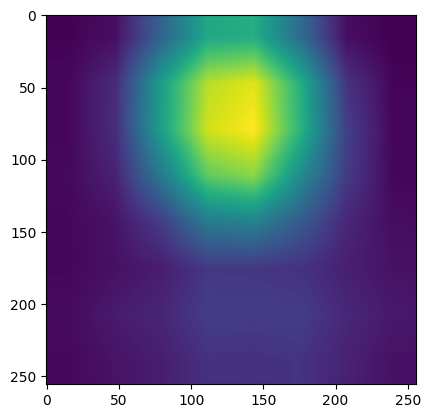

In [20]:
target_layer = resnet_model.layer4[1].conv2
wrapped_model = ScoreCAM(resnet_model, target_layer)
cam, idx = wrapped_model(input_tensor)
plt.imshow(cam.squeeze().numpy())
print(classes[idx])

In [21]:
# target_layer = regnet_model.trunk_output[3][0].f.c[0]
# wrapped_model = ScoreCAM(regnet_model, target_layer)
# cam, idx = wrapped_model(input_tensor)
# plt.imshow(cam.squeeze().numpy())
# print(classes[idx])

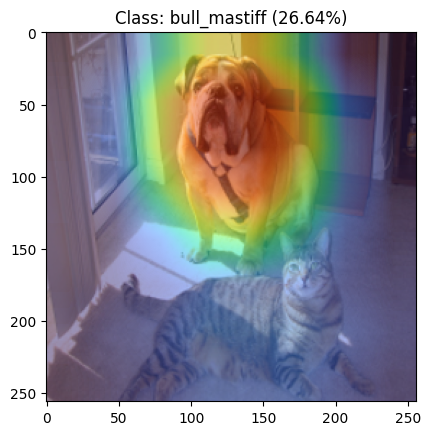

In [22]:
conv_heatmap = visualize_saliency_overlay(img, cam.squeeze().numpy(), probs, idx, classes)

In [23]:
heatmap = Image.fromarray(vit_heatmap)
heatmap = np.array(heatmap.resize((256, 256)))

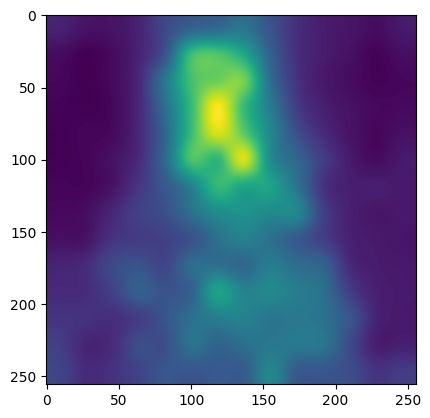

In [24]:
plt.imshow(heatmap)

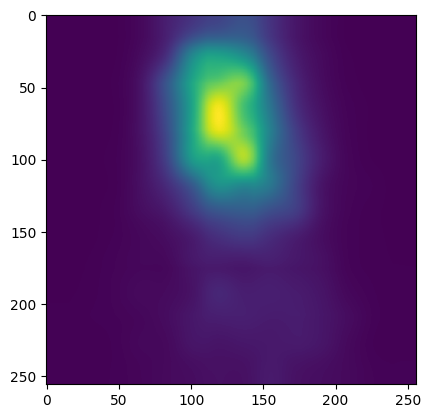

In [27]:
plt.imshow(conv_heatmap*heatmap)

In [71]:
# KL divergence
log_conv_dist = torch.log(F.softmax(torch.tensor(conv_heatmap*0.003).view(-1)))
log_deit_dist = torch.log(F.softmax(torch.tensor(heatmap*0.003).view(-1)))
kl_divergence = F.kl_div(log_conv_dist, log_deit_dist, reduction='mean')
kl_divergence

/tmp/ipykernel_2507415/1909743044.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_conv_dist = torch.log(F.softmax(torch.tensor(conv_heatmap*0.003).view(-1)))
/tmp/ipykernel_2507415/1909743044.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_deit_dist = torch.log(F.softmax(torch.tensor(heatmap*0.003).view(-1)))
/scratch/hashimi/python/lib/python3.8/site-packages/torch/nn/functional.py:2916: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


tensor(nan)

/tmp/ipykernel_2507415/3732513997.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ten = F.softmax(torch.tensor(heatmap*0.003).view(-1))


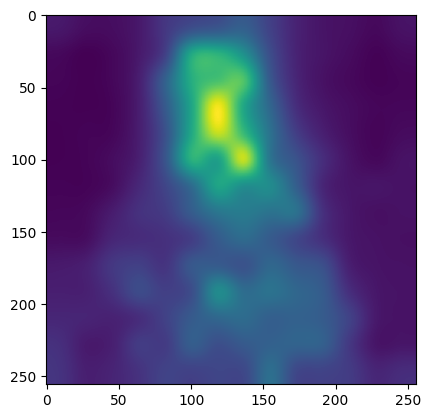

In [68]:
ten = F.softmax(torch.tensor(heatmap*0.003).view(-1))
plt.imshow(ten.view(256, 256))

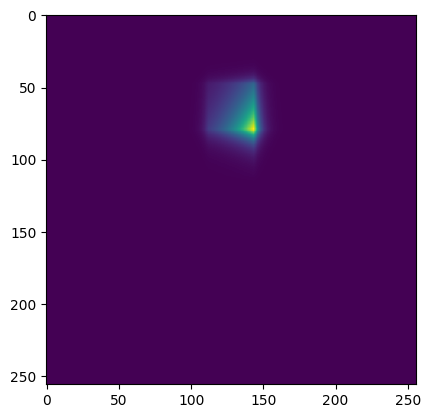

## Export

In [7]:
import nbdev
#| hide
nbdev.nbdev_export("inter_model_saliency.ipynb");

InterpolationMissingOptionError: Bad value substitution: option 'lib_name' in section 'DEFAULT' contains an interpolation key 'repo' which is not a valid option name. Raw value: '%(repo)s'